# Защита персональных данных клиентов

## Описание проекта

### Задача

Необходимо защитить данные клиентов страховой компании «Хоть потоп» и разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Так же необходимо проверить корректность работы этого метода и убедиться, что при преобразовании данных качество моделей машинного обучения не ухудшалось.

### Описание данных

**Признаки (данные по застрахованномы лицу):**
* `пол`
* `возраст`
* `зарплата`
* `количество членов семьи`.

**Целевой признак:**
* `количество страховых выплат клиенту за последние 5 лет`

### План работы

* Загрузка данных
* Изучение и подготовка данных
* Изучение влияния на качество линейной регрессии умножения на обратимую матрицу
* Матричная реализация алгоритма преобразования данных
* Общие выводы

## Импорты и настройки

In [1]:
# Импорты
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [2]:
# Настройки
np.random.seed(777)

## Загрузка данных

In [3]:
# Загрузка данных
try:
    original_df = pd.read_csv('/datasets/insurance.csv')
    display('Данные из практикума загружены.')
except:
    original_df = pd.read_csv('datasets/insurance.csv')
    display('Локальные данные загружены.')

original_df.name = 'original_df'

'Локальные данные загружены.'

In [4]:
# Первоначальный осмотр
display(original_df.head())
display(original_df.tail())
display(original_df.info())

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0
4999,1,28.0,40600.0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

**Выводы:**
* 5000 строк, 4 фичи, 1 таргет.
* Пропусков нет.
* Все данные числовые (непрямых дублей нет из-за характера данных).
* Типы определились корректно.

## Изучение и подготовка данных

In [5]:
# Создадим рабочую копию датафрейма
df = original_df.copy()

In [6]:
# Переименуем столбцы
df.columns = ['sex', 'age', 'wage', 'family_size', 'number_of_insurance_payments']

In [7]:
# Посмотрим на наличие прямых дубликатов (непрямых тут нет т.к. данные исключительно числовые)
df.duplicated().sum()

153

In [8]:
# Удалим прямые дубликаты
display(df.shape[0])
df.drop_duplicates(inplace=True)
display(df.shape[0])

5000

4847

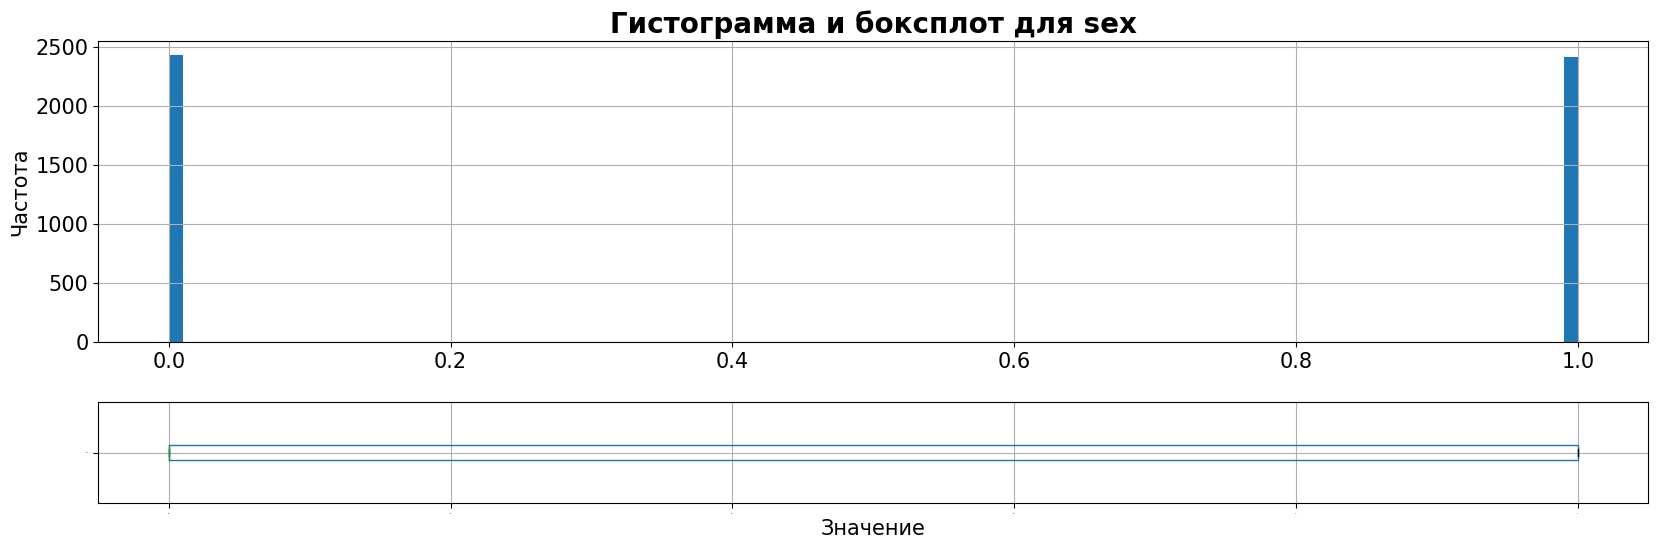

'Количество уникальных значений в столбце sex: 2'

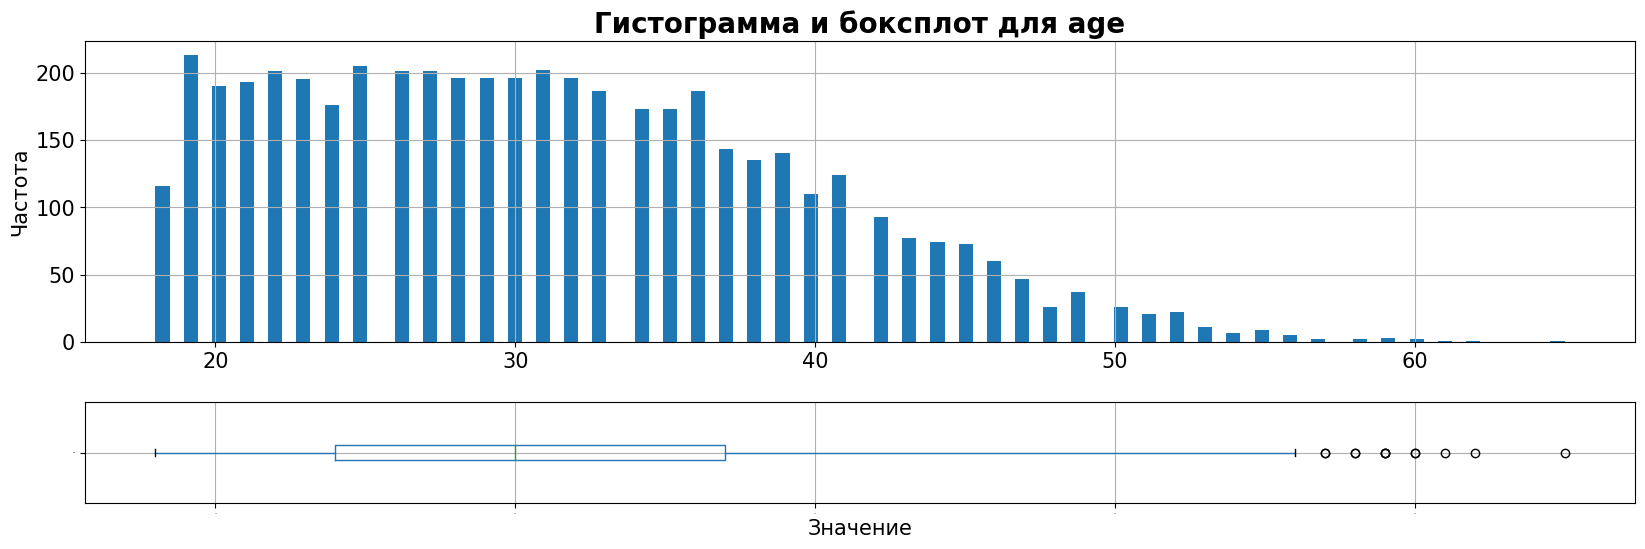

'Количество уникальных значений в столбце age: 46'

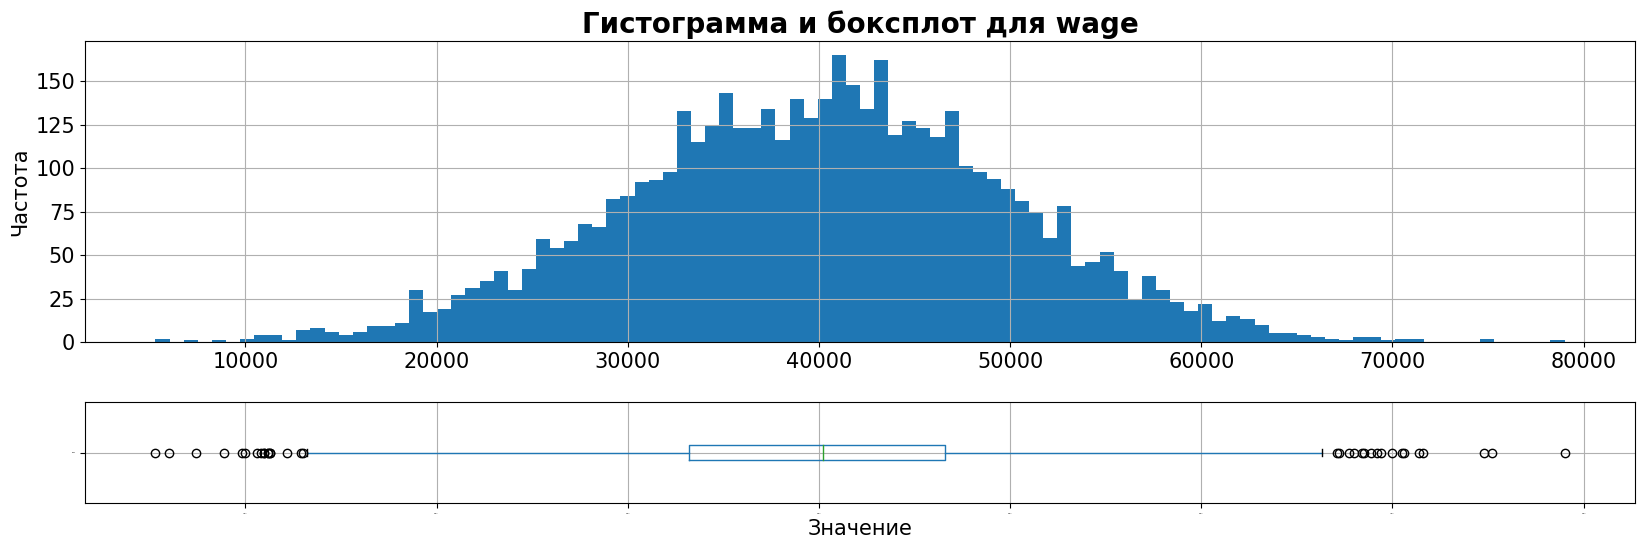

'Количество уникальных значений в столбце wage: 524'

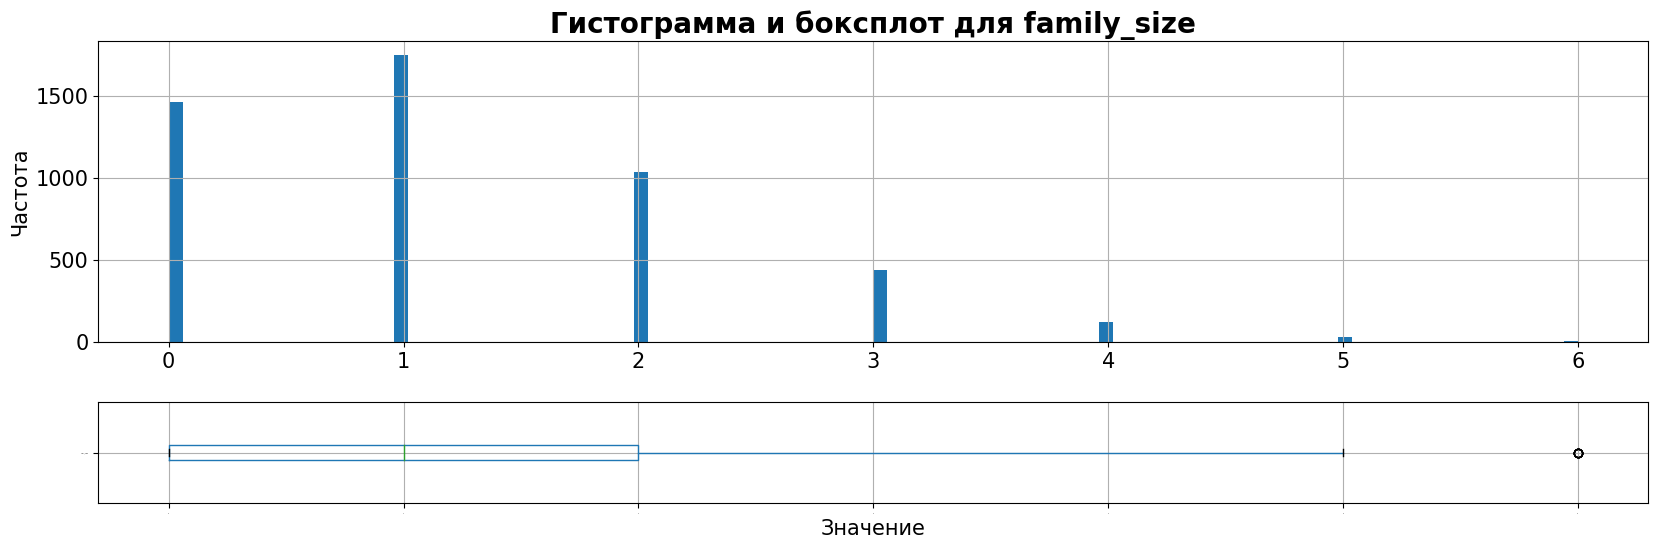

'Количество уникальных значений в столбце family_size: 7'

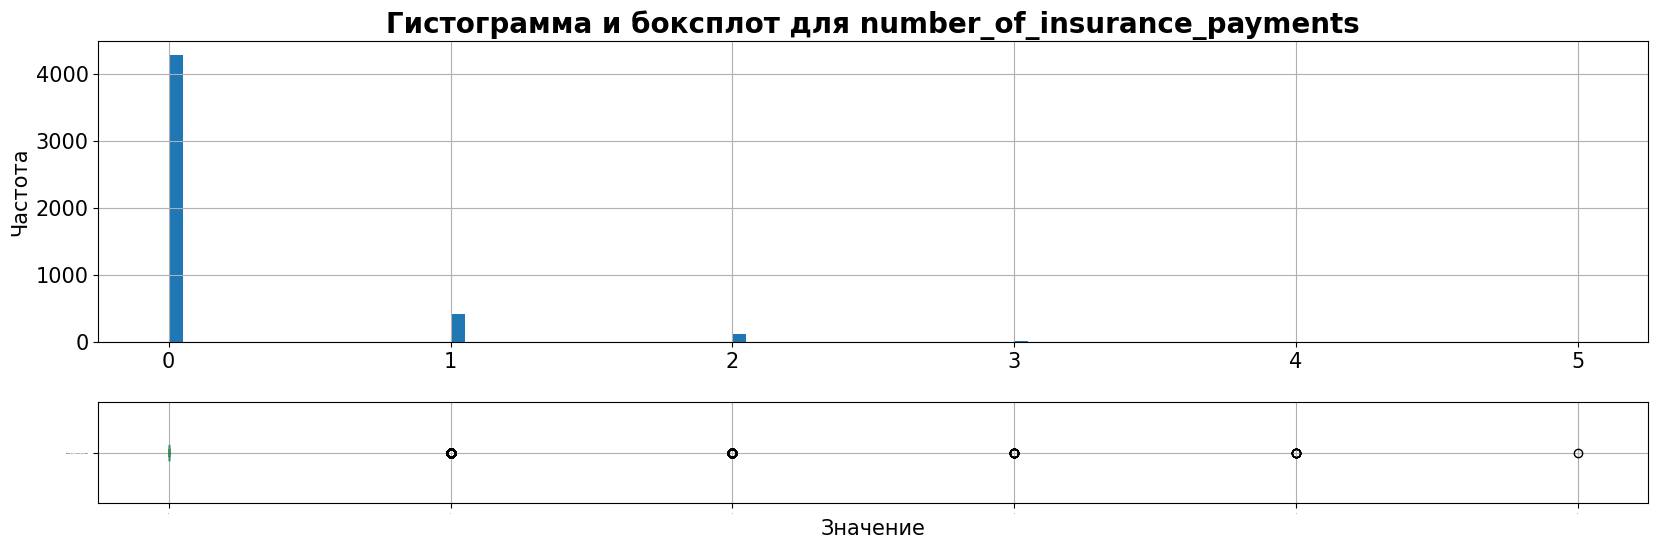

'Количество уникальных значений в столбце number_of_insurance_payments: 6'

In [9]:
# Сделаем визуализацию данных через гистограммы и боксплоты (для категориальных столбцов так же построим гистограммы, чтобы не усложнять код)
def hist_boxplot_visualizator(df):
    for column in df.columns:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), gridspec_kw={'height_ratios': [3, 1]})
        df.hist(column=column, bins=100, ax=ax1)
        df.boxplot(column=column, vert=False, ax=ax2)
        ax1.set_title(f'Гистограмма и боксплот для {column}', fontsize=20, weight='bold')
        ax1.set_ylabel('Частота', fontsize=15)
        ax1.tick_params(axis='both', labelsize=15)
        ax2.set_xlabel('Значение', fontsize=15)
        ax2.tick_params(axis='both', labelsize=0)
        plt.show()
        display(f'Количество уникальных значений в столбце {column}: {df[column].value_counts().shape[0]}')


hist_boxplot_visualizator(df)

**Выводы:**
* Названия столбцов приведены в порядок.
* Удалены 153 прямых дубликата.
* Визуализация данных говорит о том, что они чистые. Очевидных выбросов нет, распределения красивые.
* В данных примерно в одинаковом количестве представлены оба пола.
* В целевом столбце абсолютное большинство значений - нулевые.

## Изучение влияния на качество линейной регрессии умножения на обратимую матрицу


### Математическое обоснование для случая линейной регрессии

* Поиск оптимальных значений параметров линейной регрессии может быть выполнен аналитически.
* Формула поиска такого решения:
$$
w = (X^T X)^{-1} X^T y
$$
* Сами результаты можно получить по формуле:
$$
y_t = X_t w = X_t (X^T X)^{-1} X^T y
$$
* Заменим теперь Х в формулах на X * P, где P - обратимая матрица и рассчитаем:
$$
w' = ((XP)^T XP)^{-1} (XP)^T y = (P^T X^T X P)^{-1} P^T X^T y = P ^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y = P^{-1} (X^T X)^{-1} X^T y = P^{-1} w
$$
$$y_t' = X_t P w' = X_t P P^{-1} w = X_t w = y_t$$
* Таким образом математически доказано, что результаты регрессии после умножения признаков на обратимую матрицу останутся неизменными. При этом параметры новой регрессии будут связаны с параметрами оригинальной следующим образом:
$$
w' = P^{-1} w
$$


### Проверка в коде

**Алгоритм проверки в коде будет следующим:**

**Часть 1**
* Создаём отдельные датафреймы для фич и таргета.
* Создаём метод для расчёта результатов для определенной модели(идёт на вход):
    * Создаём KFold для проверки результатов на 5 подмножествах для обучения.
    * Создаём скейлер для стандартного приведения диапазонов в столбцах к [0, 1].
    * Объединяем скейлер и модель в пайплайн.
    * Делаем рассчёт R2 по кроссвалидации для 5 различных выборок.
    * Выдаём среднюю оценку.
* Создаём модель линейной регрессии.
* Подаём модель и отдельные датасеты для фич и таргета в метод и получаем первый результат.

**Часть 2**
* Создаём рандомным генератором матрицу P размера [k x k], где k - количество фич. Таким образом после умножения X на P - размерность итоговой матрицы не изменится.
* Проверяем, что матрица несингулярна (детерминант не равен нулю). Если матрица сингулярна - возвращаемся на предыдущий шаг.
* Создадим зашифрованную версию данных X_encrypted = X @ P. Размерность не изменится.
* Подадим на фход метода из Части 1 ту же модель, тот же y, но X заменим на X_encrypted и получаем второй результат.
* Сравниваем первый результат со вторым. Если расхождений нет - значит теория подтвердилась практикой и мы всё сделали верно.

In [10]:
# Выделим фичи и таргет
X = df.drop(columns=df.columns[-1])
y = df.iloc[:, -1:]

In [11]:
# Создадим модель линейной регрессии и проверим результаты её работы на имеющихся данных
def cv_r2_results(X, y, model):
    """Выдаёт средний R2 по kf для линейной регрессии на входящих данных."""

    # Подготовим модель, скейлер и кроссвалидацию
    k_fold = KFold(n_splits=5)
    scaler = StandardScaler()
    pipe = Pipeline([('scaler', scaler), ('mode', model)])

    # Рассчитаем r2
    cv_results = cross_val_score(estimator=pipe, cv=k_fold, X=X, y=y, scoring='r2')
    return cv_results.mean()

model = LinearRegression()
display(f'Средний R2 по линейной регрессии на оригинальных данных: {cv_r2_results(X, y, model):.2%}')

'Средний R2 по линейной регрессии на оригинальных данных: 42.78%'

In [12]:
# Сгенерируем обратимую матрицу с проверкой на несингулярность
def get_rand_matrix(df):
    det = 0
    while det == 0:
        matrix = np.random.random(size=(df.shape[1], df.shape[1]))
        det = np.linalg.det(matrix)
    return matrix

matrix = get_rand_matrix(X)
matrix

array([[0.15266373, 0.30235661, 0.06203641, 0.45986034],
       [0.83525338, 0.92699705, 0.72698898, 0.76849622],
       [0.26920507, 0.64402929, 0.09337326, 0.07968589],
       [0.58961375, 0.34334054, 0.98887615, 0.62647321]])

In [13]:
# Создадим зашифрованную версию X
X_encrypted = pd.DataFrame(X.values @ matrix, columns=['feature1', 'feature2', 'feature3', 'feature4'])
display(X_encrypted.head())

,feature1,feature2,feature3,feature4
0,13387.558963,31982.505463,4662.171000,3985.014605
1,10268.803795,24516.098303,3582.614129,3064.040953
2,5677.528744,13551.498048,1981.921074,1695.689988
3,11244.570820,26876.175098,3910.909331,3340.292797
4,7049.791993,16835.422797,2457.459731,2101.779369


In [14]:
display(f'Средний R2 по линейной регрессии на зашифрованных данных: {cv_r2_results(X_encrypted, y, model):.2%}')

'Средний R2 по линейной регрессии на зашифрованных данных: 42.78%'

**Выводы:**
* Сгенерирована рандомная обратимая матрица. На её основе сгенерирован новый датайфрейм с зашифрованными данными.
* Визуально интерпретировать их на глаз довольно проблематично. Восстановить первоначальную персональную информацию по таким данным будет довольно непросто.
* Данное преобразование (умножение матрицы фич на обратимую матрицу) является частным случаем аффинного преобразования. По сути к точкам из оригинального датасета в пространстве применены различные сдвиги, растяжения, которые не нарушают внутренние линейные взаимосвязи (при аффинном преобразовании параллельные прямые переходят в параллельные прямые, пересекающиеся — в пересекающиеся, скрещивающиеся — в скрещивающиеся). Поэтому и результаты обучения на оригинальных и преобразованных данных не изменяются.
* Этот факт подтверждается экспериментально. R2 в обоих случаях составляет 42.78%.
* **В итоге:** создан алгоритм преобразования данных для решения задачи.

## Матричная реализация алгоритма преобразования данных


In [15]:
# Реализуем собственный матричный эстиматор для линейной регрессии
class MatrixLinearRegression:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        X = X.values
        y = y.values
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        X = X.values
        return X @ self.w

In [16]:
# Добавим bias в оригинальный датафрейм
df_with_bias = df.copy()
df_with_bias.insert(0, 'bias', 1)

In [17]:
# Выделим фичи и таргет
X = df_with_bias.drop(columns=df_with_bias.columns[-1])
y = df_with_bias.iloc[:, -1:]

In [18]:
# Произведем матричный расчёт оптимальных коэффициентов w для оригинальных данных
model = MatrixLinearRegression()
kf = KFold(n_splits=5)
results = []
for (train_index, test_index) in kf.split(X):
    model.fit(X.iloc[train_index], y.iloc[train_index])
    pred = model.predict(X.iloc[test_index])
    results.append(r2_score(y.iloc[test_index], pred))

display(f'Средний R2 по линейной регрессии на зашифрованных данных: {sum(results)/ len(results):.2%}')

'Средний R2 по линейной регрессии на зашифрованных данных: 42.78%'

In [19]:
# Проделаем то же самое, но с умножением фич на рандомную матрицу.
# Добавим bias в зашифрованный дадафрейм (берем уже готовый)
X_encrypted.insert(0, 'bias', 1)

# Произведем матричный расчёт оптимальных коэффициентов w для оригинальных данных
model = MatrixLinearRegression()
kf = KFold(n_splits=5)
results = []
for (train_index, test_index) in kf.split(X):
    model.fit(X_encrypted.iloc[train_index], y.iloc[train_index])
    pred = model.predict(X_encrypted.iloc[test_index])
    results.append(r2_score(y.iloc[test_index], pred))

display(f'Средний R2 по линейной регрессии на зашифрованных данных: {sum(results)/ len(results):.2%}')

'Средний R2 по линейной регрессии на зашифрованных данных: 42.78%'

**Выводы:**
* Качество результатов линейной регрессии не зависит от выбора матричного или градиентного подхода.
* На качество результатов линейной регрессии не влияет умножение матрицы признаков на обратимую матрицу.

## Общие выводы

* Изучены данные компании "Хоть потоп". Данные чистые, без выбросов, пропусков.
* В данных есть небольшое количества прямых дублей. Дубли удалены.
* Целевой признак состоит преимущественно из 0.
* Предложен способ шифрования данных умножением на сгенерированную обратимую матрицу. Результат шифрования позволяет использовать обработанные данные для машинного обучения.
* Подход теоретически обоснован, выведено соотношение между параметрами модели обученной на оригинальных данных и на зашифрованных. Проведена эмпирическая проверка работы подхода, описан алгоритм такой проверки.
* Написан матричный алгоритм обучения линейной регрессии. Результаты проверены и совпадают с градиентным алгоритмом sklearn.